<a href="https://colab.research.google.com/github/Sinamhd9/GradCAM-Playground/blob/main/GradCAM_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grad-CAM

Gradient-weighted Class Activation Mapping (Grad-CAM), uses the gradients of any target class flowing into the final convolutional
layer to produce a coarse localization map highlighting the
important regions in the image for predicting the class. 

Here is a implementation of Grad-CAM that you can play with. You can choose your model (VGG16, ResNet152V2, InceptionV3, Xception), your desired layer (the final conv layer or any other layer), and define the number of top predictions. Increase alpha for more intense overlay of the heatmap on the original image.
Simply, upload your image and enjoy!

[Reference](https://arxiv.org/pdf/1610.02391.pdf)

In [74]:
#@title Importing required libraries

import tensorflow as tf
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet152V2, Xception
from tensorflow.keras.applications.vgg16 import preprocess_input as prep_vgg
from tensorflow.keras.applications.resnet_v2 import preprocess_input as prep_res
from tensorflow.keras.applications.inception_v3 import preprocess_input as prep_incp
from tensorflow.keras.applications.xception import preprocess_input as prep_xcep
from tensorflow.keras import Model
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np

In [75]:
#@title Loading pretrained model
Pretrained_Model = "VGG16" #@param ["VGG16", "ResNet152V2", "InceptionV3", "Xception"]
if Pretrained_Model == 'VGG16':
  model = VGG16()
elif Pretrained_Model == 'ResNet152V2':
  model = ResNet152V2()
elif Pretrained_Model == 'InceptionV3':
  model = InceptionV3()
elif Pretrained_Model == 'Xception':
  model = Xception()

In [76]:
#@title Here is the model summary! **Choose your desired layer**.
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [77]:
#@title Main functions
def load_process(img):
  """
    load_process function that gets an image and returns the processed image based on the model chosen.
    :param model: pretrained chosen model
    :param img: the input image
    :return: preprocessed image 
    """ 
  if model.name == 'vgg16':
      img = img_to_array(load_img(img, target_size = (224, 224)))
      img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
      img = prep_vgg(img)
  elif model.name== 'resnet152v2':
      img = img_to_array(load_img(img, target_size = (224, 224)))
      img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
      img = prep_res(img)
  elif model.name== 'inception_v3':
      img = img_to_array(load_img(img, target_size = (299, 299)))
      img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
      img = prep_incp(img)
  elif model.name== 'xception':
      img = img_to_array(load_img(img, target_size = (299, 299)))
      img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
      img = prep_xcep(img)
  return img

def return_labels(img, top_class = 3):
  """
    return_labels function that gets an image and returns the labels of prediction based on imagenet.

    :param img: the input image
    :param top_class: the number of desired top predicted targets
    :return: top labels 
    """ 
  pred = model.predict(img)
  top_labels = decode_predictions(pred, top_class)
  return top_labels[0]

def grad_cam(input_image, model, layer_name, top_class = 1):
  """
    grad_cam main function.
    :param input_image: the input image
    :param model: the pretrained model
    :param layer_name: layer name to get the gradient with respect to the target class
    :return: min-max normalized gradcam output
    """ 
    
  desired_layer = model.get_layer(layer_name)
  grad_model = Model(model.inputs, [desired_layer.output, model.output])

  with tf.GradientTape() as tape:
    layer_output, preds = grad_model(input_image)
    ix = (np.argsort(preds, axis=1)[:, -top_class]).item()
    output_idx = preds[:, ix]

  gradient = tape.gradient(output_idx, layer_output)
  alpha_kc = np.mean(gradient, axis=(0,1,2))
  L_gradCam = tf.nn.relu(np.dot(layer_output, alpha_kc)[0])
  L_gradCam = (L_gradCam - np.min(L_gradCam)) / (np.max(L_gradCam) - np.min(L_gradCam)) 
  return L_gradCam.numpy()

def blend(original_img, gradCam_img, alpha, colormap = cv2.COLORMAP_JET):
  """
    blend function to superimpose the heatmap and original image.

    :param original image: the original image
    :param gradCam_img: the output of grad_cam function
    :param alpha: a float between 0 to 1, the degree of overlay transparency
    :param colormap: desired colormap, default JET
    :return: heatmap image and the final superimposed image
    """ 
  img = img_to_array(load_img(original_img))
  gradCam_resized = cv2.resize(gradCam_img, (img.shape[1], img.shape[0]), interpolation = cv2.INTER_LINEAR)
  heatmap  = cv2.applyColorMap(np.uint8(gradCam_resized*255), colormap)
  superimposed_image = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR) + heatmap * alpha
  return heatmap, superimposed_image

def show_results(img_path, layer_name, top_class, alpha=0.5):

  img = load_process(img_path)
  top_labels_img = return_labels(img, top_class= top_class)
  for i in range(top_class):
    print('-----------------------------------------------------------')
    grad_cam_img = grad_cam(img, model, layer_name, top_class = i+1)
    print(top_labels_img[i][1], round(top_labels_img[i][2]*100, 2),'%')
    heatmap_img, result_img = blend(img_path, grad_cam_img, alpha)
    cv2_imshow(result_img)

# Results

In [71]:
#@title Upload your test file!
from google.colab import files
your_file = files.upload()

Saving 3.jpg to 3 (4).jpg


-----------------------------------------------------------
Shih-Tzu 86.7 %


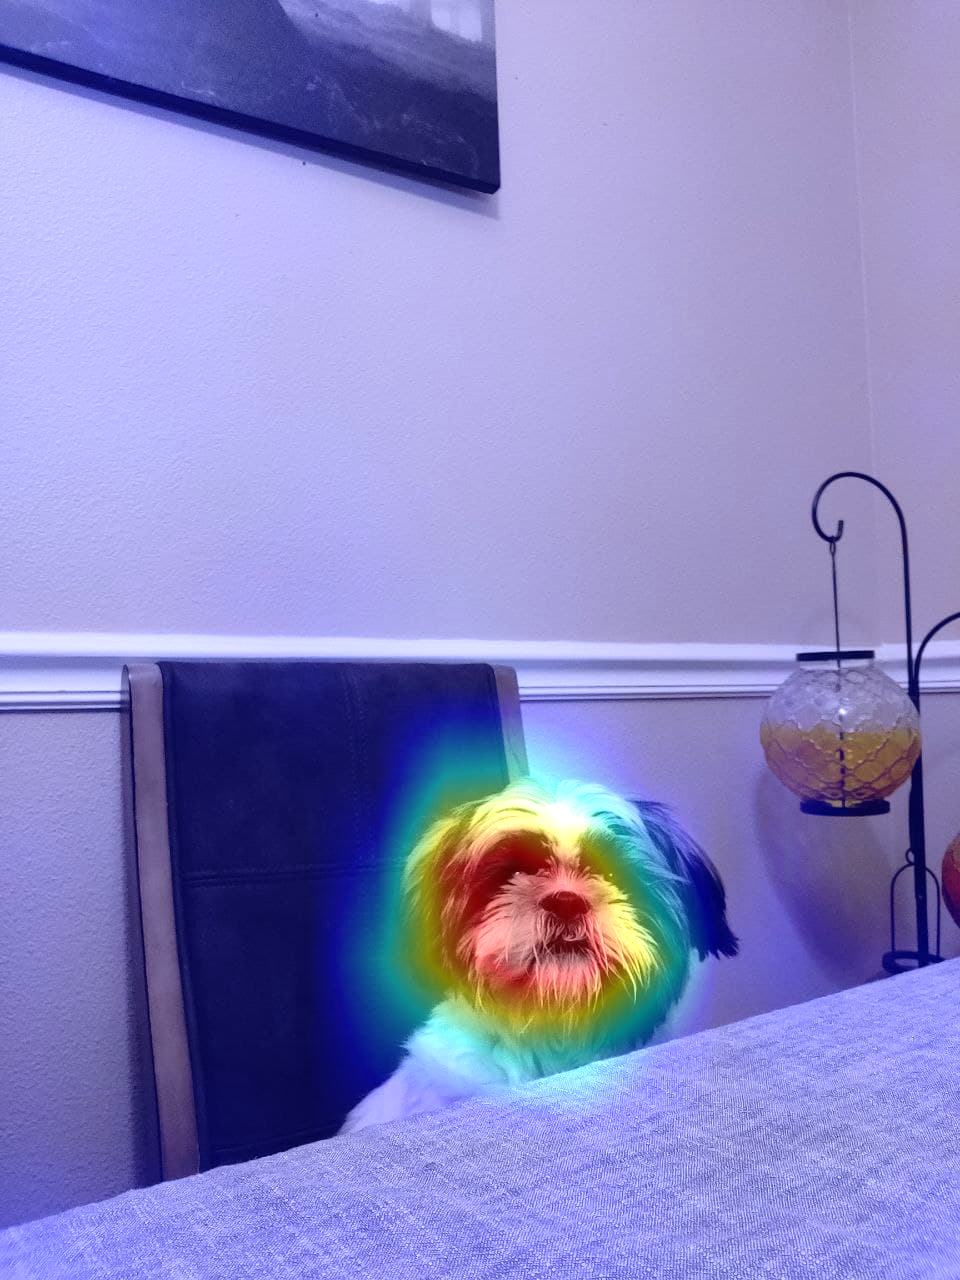

-----------------------------------------------------------
Lhasa 11.12 %


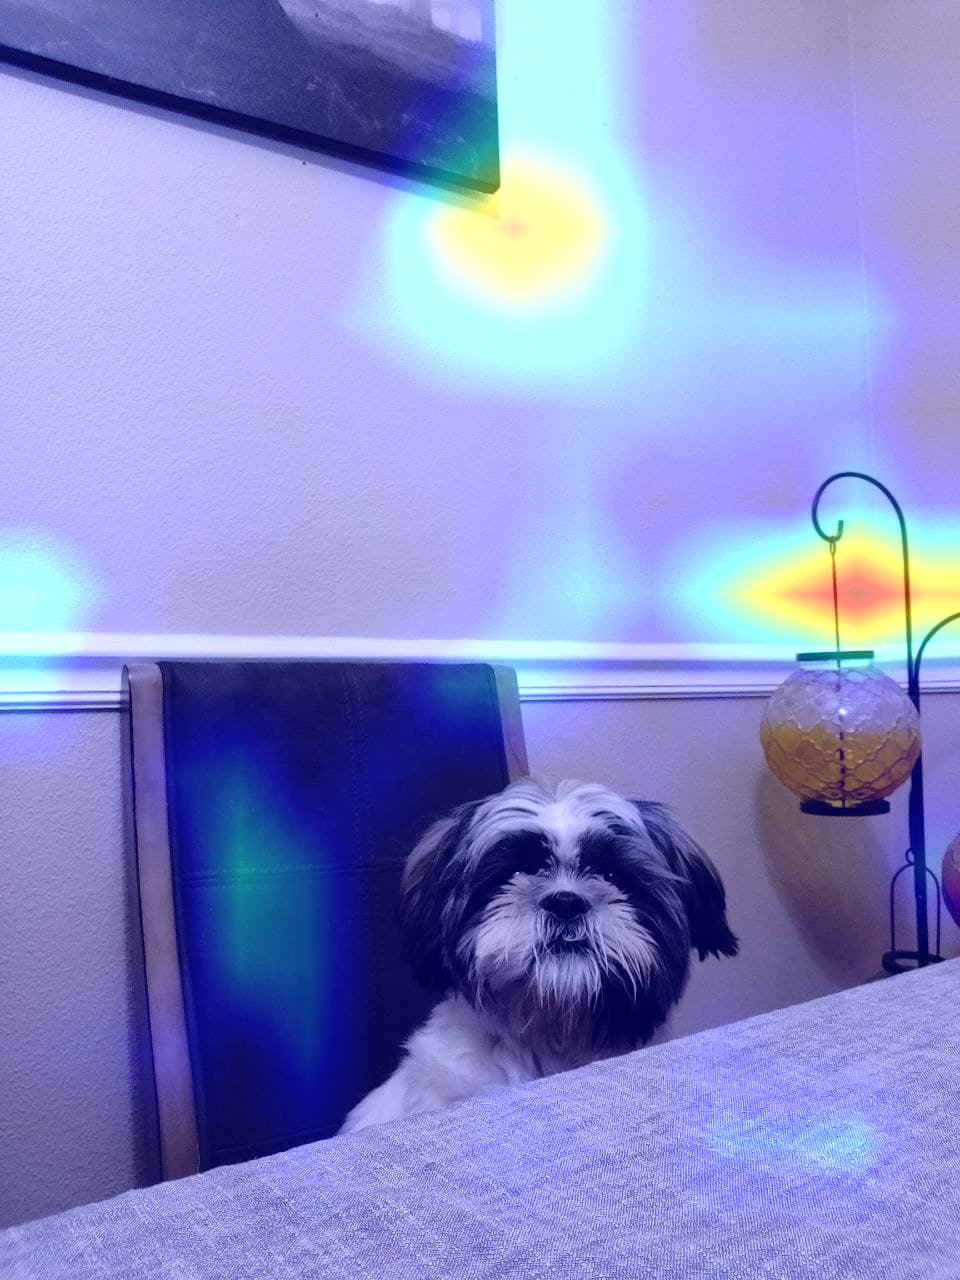

-----------------------------------------------------------
Pekinese 1.65 %


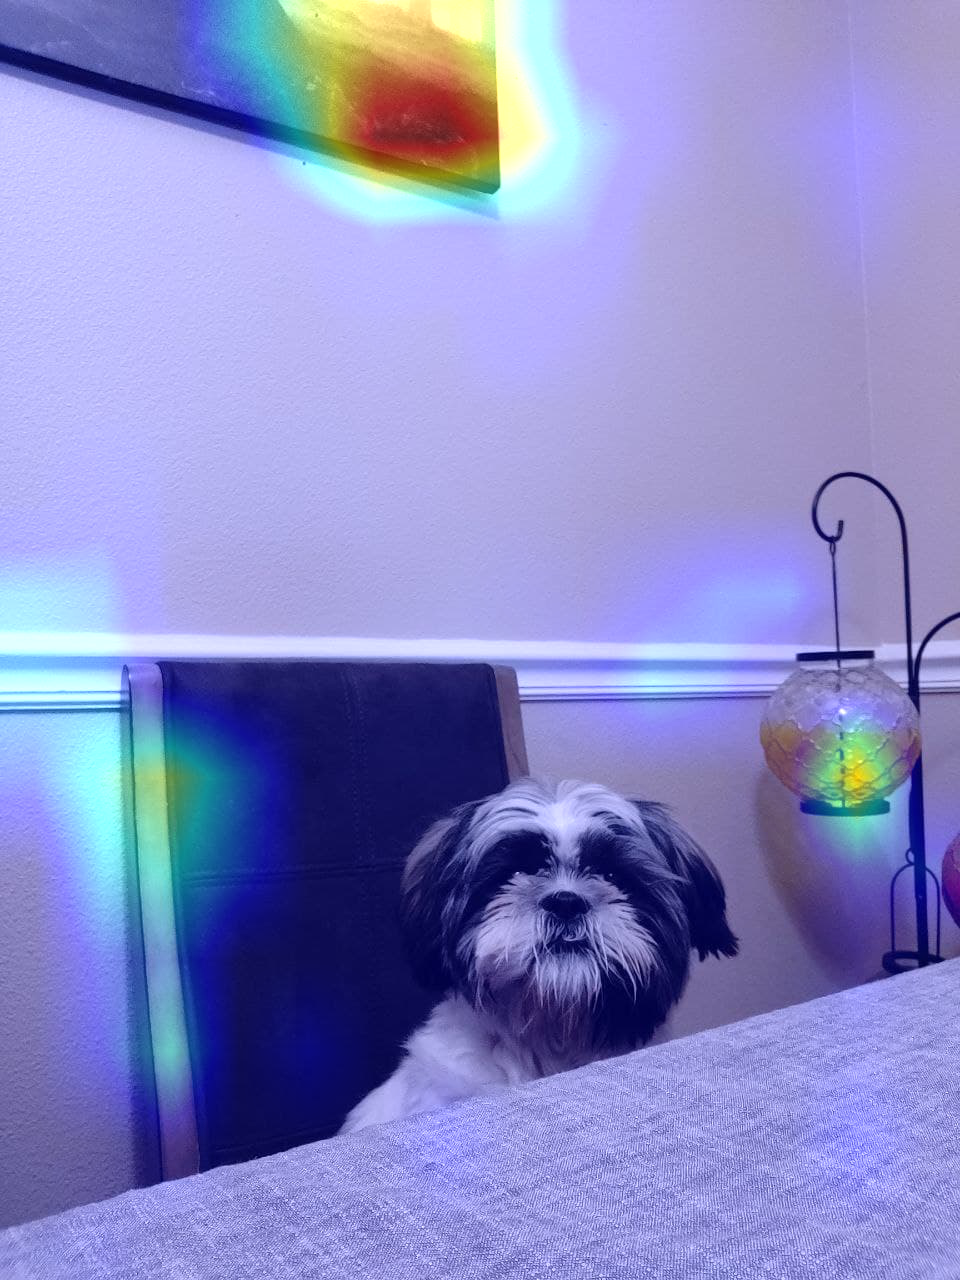

In [78]:
desired_layer = 'block5_conv3' #@param {type:"string"}
num_preds =  3#@param {type:"integer"}
alpha = 0.5 #@param {type: "slider", min:0.1, max:0.9, step:0.1}
show_results(list(your_file.keys())[0], desired_layer, num_preds, alpha=alpha)